In [1]:
import os
import sys
from pathlib import Path

In [2]:
# Set up proper directory paths

project_path = Path().absolute().parent
src_path = project_path.joinpath("src")

# Ensure the paths are properly assigned
# If this assertion fails, change project_dir as needed to become the project directory
# If project_dir is correct, change the name in the assertion check
assert project_path.name == "project-athena", "Parent directory name assertion failed (check the path)"

In [3]:
# Add src_dir to module paths
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

In [4]:
import time

import numpy as np

In [5]:
from matplotlib import pyplot as plt

In [6]:
from attacks.attack import generate
from models.athena import ENSEMBLE_STRATEGY, Ensemble
from utils.data import subsampling
from utils.file import load_from_json, dump_to_json
from utils.metrics import error_rate, get_corrections
from utils.model import load_lenet, load_pool

Using TensorFlow backend.
H:\Programs\Anaconda\envs\env_name\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
H:\Programs\Anaconda\envs\env_name\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
H:\Programs\Anaconda\envs\env_name\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
H:\Programs\Anaconda\envs\env_name\lib\site-packag

In [7]:
# copied from tutorials/craft_adversarial_examples.py
def generate_ae(model, data, labels, attack_configs,
                eot=False,
                save=False, output_dir=None):
    """
    Generate adversarial examples
    :param model: WeakDefense. The targeted model.
    :param data: array. The benign samples to generate adversarial for.
    :param labels: array or list. The true labels.
    :param attack_configs: dictionary. Attacks and corresponding settings.
    :param save: boolean. True, if save the adversarial examples.
    :param output_dir: str or path. Location to save the adversarial examples.
        It cannot be None when save is True.
    :return:
    """
    img_rows, img_cols = data.shape[1], data.shape[2]
    num_attacks = attack_configs.get("num_attacks")
    data_loader = (data, labels)

    if len(labels.shape) > 1:
        labels = np.asarray([np.argmax(p) for p in labels])

    # generate attacks one by one
    for id in range(num_attacks):
        key = "configs{}".format(id)
        attack_args = attack_configs.get(key)
        
        description = attack_args['description']
        
        attack_args["eot"] = eot
        
        data_adv = generate(model=model,
                            data_loader=data_loader,
                            attack_args=attack_args)
        
        # predict the adversarial examples
        predictions = model.predict(data_adv)
        predictions = np.asarray([np.argmax(p) for p in predictions])

        err = error_rate(y_pred=predictions, y_true=labels)
        print(">>> error rate:", err)

        # plotting some examples
        num_plotting = min(data.shape[0], 2)
        for i in range(num_plotting):
            img = data_adv[i].reshape((img_rows, img_cols))
            plt.imshow(img, cmap='gray')
            title = '{}: {}->{}'.format(description,
                                        labels[i],
                                        predictions[i])
            plt.title(title)
            plt.savefig(project_path.joinpath(f"results/{description}-{i}.png"))
            plt.show()
            plt.close()

        # save the adversarial example
        if save:
            if output_dir is None:
                raise ValueError("Cannot save images to a none path.")
            # save with a random name
            file = os.path.join(output_dir, f"{description}.npy")
            print("Save the adversarial examples to file [{}].".format(file))
            np.save(file, data_adv)

In [8]:
# Load data configs
file = project_path.joinpath("Task2/configs/data-mnist.json")
data_configs = load_from_json(file)

trans_configs = load_from_json(project_path.joinpath("Task2/configs/athena-mnist.json"))
model_configs = load_from_json(project_path.joinpath("Task2/configs/model-mnist.json"))

# In the context of the white-box threat model,
# we use the ensemble as adversary's target model.
pool, _ = load_pool(trans_configs=trans_configs,
                    model_configs=model_configs,
                    active_list=True,
                    wrap=True)

# create an AVEP ensemble from the WD pool
wds = list(pool.values())
target = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.AVEP.value)

# load the benign samples
data_file = project_path.joinpath(data_configs['dir'], data_configs.get('bs_file'))
data_bs = np.load(data_file)
# load the corresponding true labels
label_file = project_path.joinpath(data_configs['dir'], data_configs.get('label_file'))
labels = np.load(label_file)


output_path = project_path.joinpath("Task2/data")

>>> Loading model [../models/cnn/model-mnist-cnn-morph_gradient.h5]...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
>>> Loading model [../models/cnn/model-mnist-cnn-distort_x.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-noise_gaussian.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-noise_sNp.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-filter_gaussian.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-geo_iradon.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-seg_gradient.h5]...
>>> Loaded 7 models.


In [ ]:
# EOT OFF
attack_configs = load_from_json(project_path.joinpath("Task2/configs/attack-zk-mnist.json"))
generate_ae(model=target, data=data_bs,labels=labels, attack_configs=attack_configs,
            save=True, output_dir=output_path)

>>> Generating PGD_eps0.05EOT_ON(EOT:ON) examples.
>>> error rate: 0.012


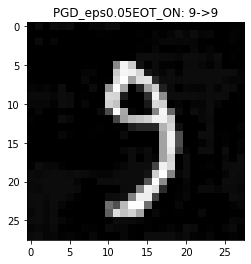

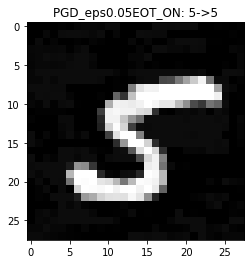

Save the adversarial examples to file [D:\GitHub\project-athena\Task2\data\PGD_eps0.05EOT_ON.npy].
>>> Generating PGD_eps0.2EOT_ON(EOT:ON) examples.
>>> error rate: 0.038


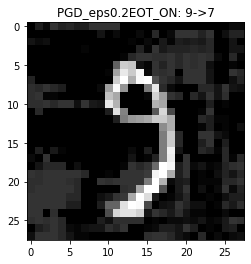

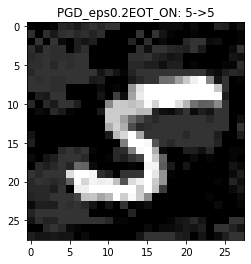

Save the adversarial examples to file [D:\GitHub\project-athena\Task2\data\PGD_eps0.2EOT_ON.npy].
>>> Generating PGD_eps0.5EOT_ON(EOT:ON) examples.
>>> error rate: 0.754


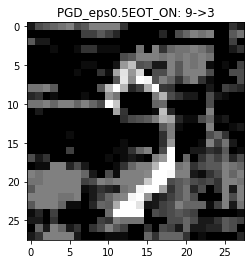

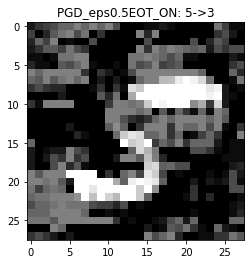

Save the adversarial examples to file [D:\GitHub\project-athena\Task2\data\PGD_eps0.5EOT_ON.npy].
>>> Generating PGD_eps0.7EOT_ON(EOT:ON) examples.
>>> error rate: 0.948


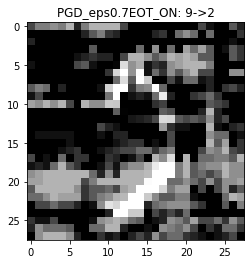

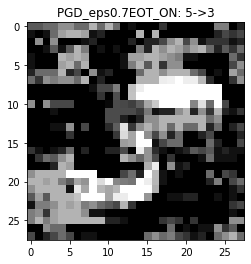

Save the adversarial examples to file [D:\GitHub\project-athena\Task2\data\PGD_eps0.7EOT_ON.npy].
>>> Generating PGD_eps0.1EOT_ON(EOT:ON) examples.
>>> error rate: 0.018


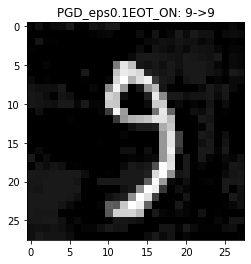

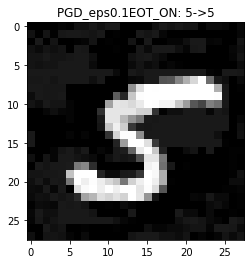

Save the adversarial examples to file [D:\GitHub\project-athena\Task2\data\PGD_eps0.1EOT_ON.npy].
>>> Generating FGSM_eps0.01EOT_ON(EOT:ON) examples.
>>> error rate: 0.01


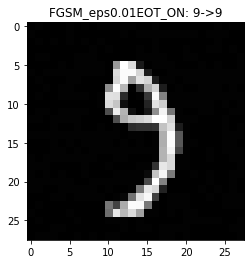

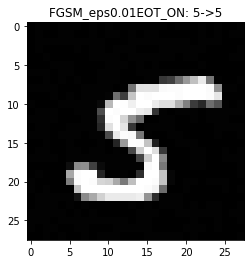

Save the adversarial examples to file [D:\GitHub\project-athena\Task2\data\FGSM_eps0.01EOT_ON.npy].
>>> Generating FGSM_eps0.05EOT_ON(EOT:ON) examples.
>>> error rate: 0.008


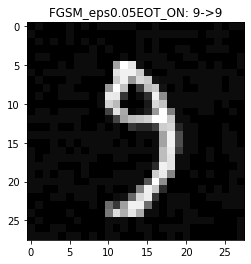

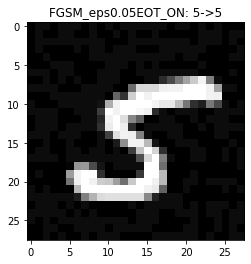

Save the adversarial examples to file [D:\GitHub\project-athena\Task2\data\FGSM_eps0.05EOT_ON.npy].
>>> Generating FGSM_eps0.1EOT_ON(EOT:ON) examples.
>>> error rate: 0.022


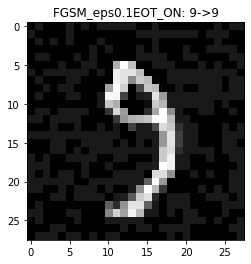

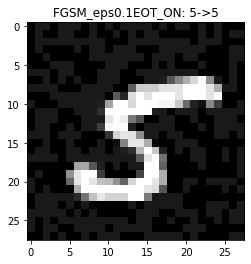

Save the adversarial examples to file [D:\GitHub\project-athena\Task2\data\FGSM_eps0.1EOT_ON.npy].
>>> Generating FGSM_eps0.2EOT_ON(EOT:ON) examples.
>>> error rate: 0.05


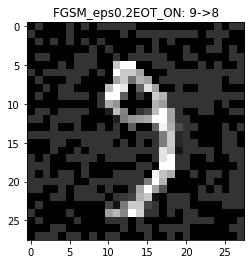

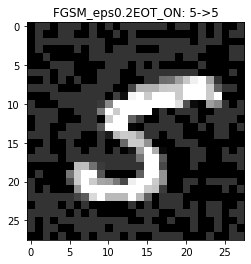

Save the adversarial examples to file [D:\GitHub\project-athena\Task2\data\FGSM_eps0.2EOT_ON.npy].
>>> Generating FGSM_eps0.5EOT_ON(EOT:ON) examples.
>>> error rate: 0.828


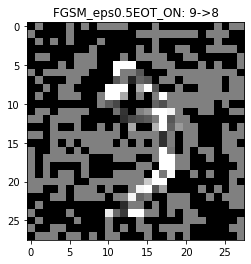

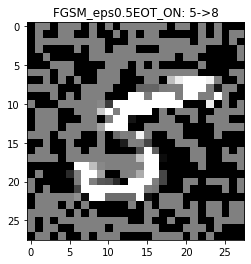

Save the adversarial examples to file [D:\GitHub\project-athena\Task2\data\FGSM_eps0.5EOT_ON.npy].


In [17]:
# EOT ON
attack_configs = load_from_json(project_path.joinpath("Task2/configs/attack-zk-mnistEOTON.json"))

# Adaptive approach (with EOT)
# Compute the loss expectation over specific distribution.
# For an ensemble target, averaging the EOT of WDs'.
# let save=True and specify an output folder to save the generated AEs
generate_ae(model=target, data=data_bs, labels=labels, eot=True, attack_configs=attack_configs, save=True, output_dir=output_path)

# Evaluating the generated adverserial example on the vanilla Athena.

In [18]:
file = project_path.joinpath("Task2/configs/data-mnist.json")
data_configs = load_from_json(file)

img_rows, img_cols = data_bs.shape[1], data_bs.shape[2]

pred_bs = target.predict(data_bs)
corrections = get_corrections(y_pred=pred_bs, y_true=labels)

results = {}

ae_files = data_configs.get('task2_aes')

for file in ae_files:
    results[file] = {}
    ae_file = project_path.joinpath(data_configs['dir'], file)
    x_adversarial = np.load(ae_file)
    print(f">>> Running evaluations on [{ae_file}]")
    pred = target.predict(x_adversarial)
    err = error_rate(y_pred=pred, y_true=labels, correct_on_bs=corrections)
    print(f">>> Error Rate of {file}: [{err}]")
    results[file] = err
    
result_file = project_path.joinpath("Task2/results/ae_evaluation_results.json")
dump_to_json(results, result_file)
print(f">>> Evaluations on all ae_files dumped to [{result_file}]")

H:\Programs\Anaconda\envs\env_name\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
H:\Programs\Anaconda\envs\env_name\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
H:\GitHub\project-athena\src\models\image_processor.py:861: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
  interpolation=interpolation, circle=circle))
H:\GitHub\project-athena\src\models\image_processor.py:73: UserWarning: Possible precision loss c

>>> Running evaluations on [H:\GitHub\project-athena\Task2\data\task2-FGSM_0.5.npy]
>>> Error Rate of task2-FGSM_0.5.npy: [0.8704453441295547]
>>> Running evaluations on [H:\GitHub\project-athena\Task2\data\task2-FGSM_eps0.1.npy]
>>> Error Rate of task2-FGSM_eps0.1.npy: [0.010121457489878543]
>>> Running evaluations on [H:\GitHub\project-athena\Task2\data\task2-FGSM_eps0.01.npy]
>>> Error Rate of task2-FGSM_eps0.01.npy: [0.0020242914979757085]
>>> Running evaluations on [H:\GitHub\project-athena\Task2\data\task2-FGSM_eps0.2.npy]
>>> Error Rate of task2-FGSM_eps0.2.npy: [0.058704453441295545]
>>> Running evaluations on [H:\GitHub\project-athena\Task2\data\task2-FGSM_eps0.05.npy]
>>> Error Rate of task2-FGSM_eps0.05.npy: [0.004048582995951417]
>>> Running evaluations on [H:\GitHub\project-athena\Task2\data\task2-PGD_eps0.1.npy]
>>> Error Rate of task2-PGD_eps0.1.npy: [0.022267206477732792]
>>> Running evaluations on [H:\GitHub\project-athena\Task2\data\task2-PGD_eps0.2.npy]
>>> Error Rat

In [9]:
# Running the baseline adversarial examples
file = project_path.joinpath("Task2/configs/data-mnist.json")
data_configs = load_from_json(file)

# load the benign samples
data_file = project_path.joinpath(data_configs['bl_dir'], data_configs.get('all_bs_file'))
data_bs = np.load(data_file)
# load the corresponding true labels
label_file = project_path.joinpath(data_configs['bl_dir'], data_configs.get('all_label_file'))
labels = np.load(label_file)

img_rows, img_cols = data_bs.shape[1], data_bs.shape[2]

pred_bs = target.predict(data_bs)
corrections = get_corrections(y_pred=pred_bs, y_true=labels)

results = {}

ae_files = data_configs.get('ae_files')

for file in ae_files:
    results[file] = {}
    ae_file = project_path.joinpath(data_configs['bl_dir'], file)
    x_adversarial = np.load(ae_file)
    print(f">>> Running evaluations on [{ae_file}]")
    pred = target.predict(x_adversarial)
    err = error_rate(y_pred=pred, y_true=labels, correct_on_bs=corrections)
    print(f">>> Error Rate of {file}: [{err}]")
    results[file] = err
    
result_file = project_path.joinpath("Task2/results/baseline_ae_evaluation_results.json")
dump_to_json(results, result_file)
print(f">>> Evaluations on all ae_files dumped to [{result_file}]")

H:\Programs\Anaconda\envs\env_name\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
H:\Programs\Anaconda\envs\env_name\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
H:\GitHub\project-athena\src\models\image_processor.py:861: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
  interpolation=interpolation, circle=circle))
H:\GitHub\project-athena\src\models\image_processor.py:73: UserWarning: Possible precision loss c

>>> Running evaluations on [H:\GitHub\project-athena\data\test_AE-mnist-cnn-clean-fgsm_eps0.1.npy]
>>> Error Rate of test_AE-mnist-cnn-clean-fgsm_eps0.1.npy: [0.011493094061901401]
>>> Running evaluations on [H:\GitHub\project-athena\data\test_AE-mnist-cnn-clean-fgsm_eps0.15.npy]
>>> Error Rate of test_AE-mnist-cnn-clean-fgsm_eps0.15.npy: [0.030345800988002825]
>>> Running evaluations on [H:\GitHub\project-athena\data\test_AE-mnist-cnn-clean-fgsm_eps0.2.npy]
>>> Error Rate of test_AE-mnist-cnn-clean-fgsm_eps0.2.npy: [0.07561246093356185]
>>> Running evaluations on [H:\GitHub\project-athena\data\test_AE-mnist-cnn-clean-fgsm_eps0.25.npy]
>>> Error Rate of test_AE-mnist-cnn-clean-fgsm_eps0.25.npy: [0.19628994858352655]
>>> Running evaluations on [H:\GitHub\project-athena\data\test_AE-mnist-cnn-clean-fgsm_eps0.3.npy]
>>> Error Rate of test_AE-mnist-cnn-clean-fgsm_eps0.3.npy: [0.39419296300030243]
>>> Running evaluations on [H:\GitHub\project-athena\data\test_AE-mnist-cnn-clean-bim_ord2_eps